# Epymorph dev log: June 30th, 2023

_author: Tyler Coles_

_updated: 2024-08-12_

Introducing epymorph's CompartmentModel system for specifying custom models (or IPMs).

You will define your model as a Python class, extending the base CompartmentModel class, and overriding class attributes and methods which together define the model's:

1. compartments (or states),
2. required data (or model parameters), and
3. transitions between compartments (or events).

CopmartmentModels are designed to be declarative, rather than procedural, in nature. That is -- these lines of code describe the structure of the IPM, without having to write complicated and repetitive logic that performs the simulation calculations. epymorph will use the structure of the model to perform the calculations for you.

Let's see it in action with a couple examples.

## The Pei Model

To recap: the Pei SIRS flu model uses a beta value that varies over time in response to local humidity.

For reference, here's the transition diagram:

![The Pei model transition diagram](./img/pei-model.png)

Where $L$ is the average period of immunity and $D$ is the mean infectious period.

And in the beta equation:

$$
\beta_t = \frac{R_{0 min} + e^{a H_t + log(R_{0 max} - R_{0 min})}}{D}
$$

$H_t$ represents humidity over time, and $a$, $R_{0 min}$, and $R_{0 max}$ are constants whose values have been derived from other research.

### Specifying the IPM

Now we get into epymorph specifics. We will first declare the model's compartments and parameters. Then we can define the transitions between compartments with rate expressions -- leveraging symbolic math library `sympy` -- using symbols which represent the compartments and parameters we declared.

In [1]:
from typing import Sequence

from sympy import exp

from epymorph.kit import *


# Declare a new class (you can name it what you like) and extend CompartmentModel
class PeiIpm(CompartmentModel):
    # 1. Declare compartments
    #   Each of our S, I, and R compartments needs a name...
    compartments = [
        compartment(
            name="S",
            description="Susceptible",  # but we can also provide a description
        ),
        compartment("I", description="Infectious"),
        compartment("R", description="Recovered"),
    ]

    # 2. Declare requirements
    #   Each needs a name, type, and the expected shape of the data
    #   (think, the shape of the numpy array of values)
    requirements = [
        AttributeDef(
            # this name is important; it's how we provide values later
            name="infection_duration",
            # the values are floating point numbers
            type=float,
            # and we'll allow time-and-node-varying data
            shape=Shapes.TxN,
            # a comment helps users know what this value means
            comment="Mean duration of infection.",
            # default_value=... (optional; if it makes sense to have a default)
        ),
        AttributeDef(
            "immunity_duration",
            float,
            Shapes.TxN,
            comment="Mean duration of immunity after recovery.",
        ),
        AttributeDef("humidity", float, Shapes.TxN, comment="Relative humidity."),
    ]

    # 3. Describe the transitions between compartments
    #   (aka, edges; the arrows from our diagram)
    def edges(self, symbols: ModelSymbols) -> Sequence[TransitionDef]:
        # This is a method because working with edges is a little more complicated.
        # We need to refer to the compartments and requirements we just defined,
        # and this method allows us to defer the calculation of these edges
        # until those references are ready.

        # Plus now that we're in a method body we can write more-involved Python
        # expressions, with variables and stuff.

        # First, extract symbols for compartments and requirements.
        # Then we'll use sympy math operators to build the rate expressions.
        [S, I, R] = symbols.all_compartments
        [D, L, H] = symbols.all_requirements

        # For example, here we build our beta function as a standalone expression.
        beta = (0.7 * exp(-180 * H) + 1.3) / D

        # But the job of the `edges()` method is to return the edge definitions
        # for the model. Each edge has a source and destination compartment, and a
        # rate expression (using sympy expressions).
        return [
            # The S -> I edge...
            edge(S, I, rate=beta * S * I / (S + I + R)),
            # The I -> R edge...
            edge(I, R, rate=I / D),
            # The R -> S edge...
            edge(R, S, rate=R / L),
        ]

### Running the simulation

Now that we have a custom CompartmentModel class, we can create an instance and pass that into our RUME, then run a simulation with the RUME.


Loading gpm:all::mm::commuters (epymorph.adrio.commuting_flows.Commuters):
  |####################| 100%  (9.632s)
Loading gpm:all::init::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (1.306s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-30 (150 days)
• 6 geo nodes
  |####################| 100%                     
Runtime: 0.150s


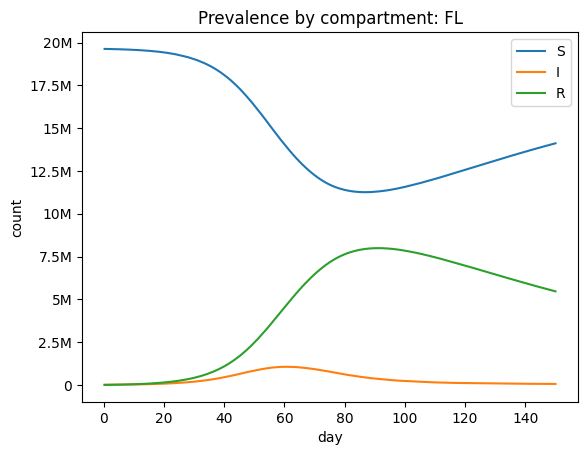

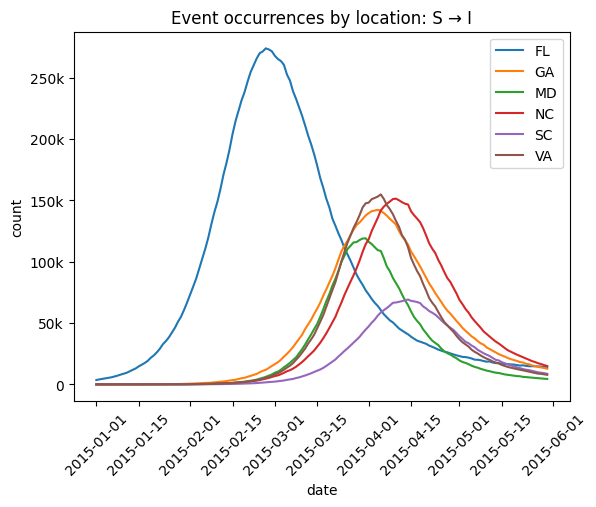

In [2]:
import epymorph.data.pei as pei
from epymorph.adrio import acs5, commuting_flows, us_tiger

rume = SingleStrataRUME.build(
    ipm=ipm.Pei(),
    mm=mm.Pei(),
    scope=pei.pei_scope,
    params={
        # movement model parameters
        "theta": 0.1,
        "move_control": 0.9,
        # IPM parameters
        # NOTE: these names match the names we declared in our IPM!
        "infection_duration": 4.0,
        "immunity_duration": 90.0,
        # geographic params
        "population": acs5.Population(),
        "centroids": us_tiger.GeometricCentroid(),
        "commuters": commuting_flows.Commuters(),
        # TODO: replace this with ADRIO when we have one for humidity
        "humidity": pei.pei_humidity,
    },
    time_frame=TimeFrame.of("2015-01-01", duration_days=150),
    init=init.SingleLocation(location=0, seed_size=10_000),
)

with sim_messaging():
    sim = BasicSimulator(rume)
    out = sim.run()

out.plot.line(
    geo=rume.scope.select.by_indices([0]),
    time=rume.time_frame.select.all(),
    quantity=rume.ipm.select.compartments(),
    title="Prevalence by compartment: FL",
    label_format="{q}",
)

out.plot.line(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().group("day").agg(),
    quantity=rume.ipm.select.events("S->I"),
    title="Event occurrences by location: S → I",
    label_format="{n}",
)

## The SPARSEMOD COVID-19 model

Now we look at constructing [a more involved model, this one for COVID-19](https://www.medrxiv.org/content/10.1101/2021.05.13.21256216v1). The most significant difference (besides that there are more states and more parameters) is that this model contains forked transitions -- that is, a set of edges which go from a common starting compartment to more than one destination compartment, sharing a base occurrence rate which is split between destinations by a simple ratio.

For example: in this model an Exposed individual ($E$) can progress either to the Infected Asymptomatic ($I_a$) or Infected Pre-symptomatic ($I_p$) compartment. The base rate (expressing individuals which transition to either of those compartments combined) is $E \delta_1$. Then $\rho_1$ of those individuals progress to $I_a$, and $1 - \rho_1$ progress to $I_p$, where $0 \le \rho_1 \le 1$.

We can also write that as two edge rates where the base rate and the proportion are pre-multiplied:

$$
E \delta_1 \rho_1
$$

$$
E \delta_1 (1 - \rho_1)
$$

CompartmentModel will use this form to _define_ forked transitions, however the epymorph engine does not treat them as wholly independent calcuations. In brief: a simple edge is resolved by a poisson draw; a fork is a poisson draw (using the base rate) followed by a multinomial draw (using the proportions).

Now let's build the compartment model. The process is the same as above, there's just more of each kind of thing to declare!

In [3]:
from typing import Sequence


class SparsemodIpm(CompartmentModel):
    compartments = [
        compartment("S", description="susceptible"),
        compartment("E", description="exposed"),
        compartment("I_a", description="infected asymptomatic"),
        compartment("I_p", description="infected presymptomatic"),
        compartment("I_s", description="infected symptomatic"),
        compartment("I_b", description="infected bed-rest"),
        compartment("I_h", description="infected hospitalized"),
        compartment("I_c1", description="infected in ICU"),
        compartment("I_c2", description="infected in ICU Step-Down"),
        compartment("D", description="deceased"),
        compartment("R", description="recovered"),
    ]

    requirements = [
        AttributeDef("beta_1", float, Shapes.TxN),
        AttributeDef("omega_1", float, Shapes.TxN),
        AttributeDef("omega_2", float, Shapes.TxN),
        AttributeDef("delta_1", float, Shapes.TxN),
        AttributeDef("delta_2", float, Shapes.TxN),
        AttributeDef("delta_3", float, Shapes.TxN),
        AttributeDef("delta_4", float, Shapes.TxN),
        AttributeDef("delta_5", float, Shapes.TxN),
        AttributeDef("gamma_a", float, Shapes.TxN),
        AttributeDef("gamma_b", float, Shapes.TxN),
        AttributeDef("gamma_c", float, Shapes.TxN),
        AttributeDef("rho_1", float, Shapes.TxN),
        AttributeDef("rho_2", float, Shapes.TxN),
        AttributeDef("rho_3", float, Shapes.TxN),
        AttributeDef("rho_4", float, Shapes.TxN),
        AttributeDef("rho_5", float, Shapes.TxN),
    ]

    def edges(self, symbols: ModelSymbols) -> Sequence[TransitionDef]:
        [S, E, I_a, I_p, I_s, I_b, I_h, I_c1, I_c2, D, R] = symbols.all_compartments
        [
            beta_1,
            omega_1,
            omega_2,
            delta_1,
            delta_2,
            delta_3,
            delta_4,
            delta_5,
            gamma_a,
            gamma_b,
            gamma_c,
            rho_1,
            rho_2,
            rho_3,
            rho_4,
            rho_5,
        ] = symbols.all_requirements

        # It's handy to specify some intermediate expressions for the total number of
        # people and our \lambda_1
        N = S + E + I_a + I_p + I_s + I_b + I_h + I_c1 + I_c2 + D + R

        lambda_1 = (omega_1 * I_a + I_p + I_s + I_b + omega_2 * (I_h + I_c1 + I_c2)) / (
            N - D
        )

        # Now define the transitions.
        return [
            edge(S, E, rate=beta_1 * lambda_1 * S),
            # This is the fork we talked about earlier! E -> {Ia,Ip}
            # Wrapping `edge`s with a `fork` alerts epymorph that these
            # should not be treated as statistically independent events,
            # but that they share a common base rate and a proportional split.
            fork(
                edge(E, I_a, rate=E * delta_1 * rho_1),
                edge(E, I_p, rate=E * delta_1 * (1 - rho_1)),
            ),
            edge(I_p, I_s, rate=I_p * delta_2),
            # And here's a fork with three destinations and two proportional parameters.
            fork(
                edge(I_s, I_b, rate=I_s * delta_3 * (1 - rho_2 - rho_3)),
                edge(I_s, I_h, rate=I_s * delta_3 * rho_2),
                edge(I_s, I_c1, rate=I_s * delta_3 * rho_3),
            ),
            fork(
                edge(I_h, I_c1, rate=I_h * delta_4 * rho_4),
                edge(I_h, R, rate=I_h * delta_4 * (1 - rho_4)),
            ),
            fork(
                edge(I_c1, D, rate=I_c1 * delta_5 * rho_5),
                edge(I_c1, I_c2, rate=I_c1 * delta_5 * (1 - rho_5)),
            ),
            edge(I_a, R, rate=I_a * gamma_a),
            edge(I_b, R, rate=I_b * gamma_b),
            edge(I_c2, R, rate=I_c2 * gamma_c),
        ]

Now run it.

Loading gpm:all::mm::commuters (epymorph.adrio.commuting_flows.Commuters):
  |####################| 100%  (9.660s)
Loading gpm:all::init::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (1.320s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-07-19 (200 days)
• 6 geo nodes
  |####################| 100%                     
Runtime: 0.442s


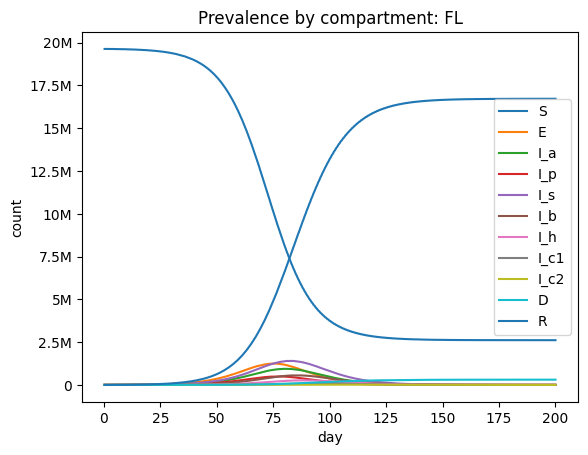

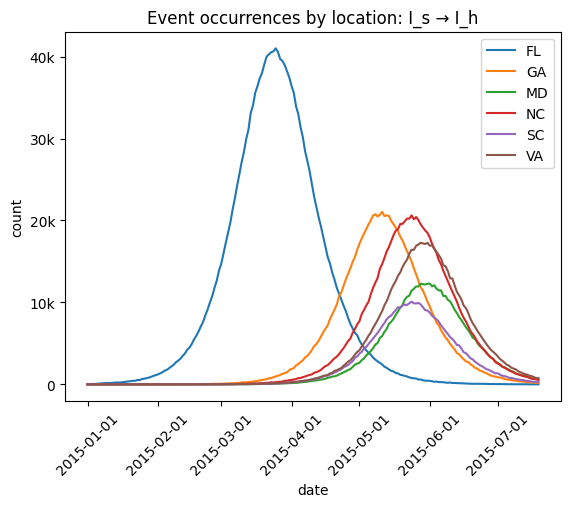

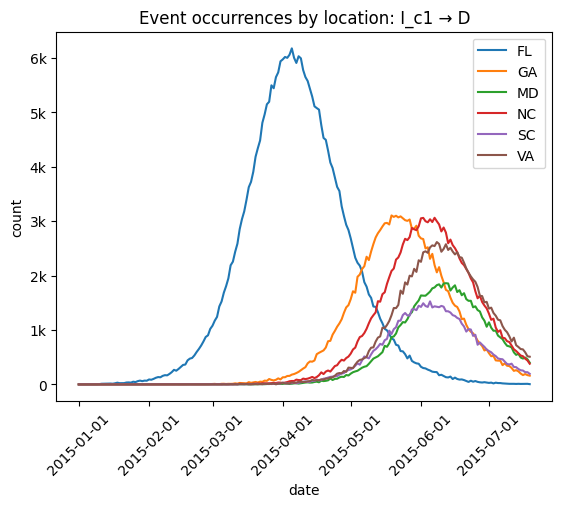

In [4]:
rume = SingleStrataRUME.build(
    ipm=SparsemodIpm(),
    mm=mm.Pei(),
    scope=pei.pei_scope,
    params={
        # movement model params
        "move_control": 1,
        "theta": 0.1,
        # IPM params
        "beta_1": 0.3,
        "omega_1": 0.55,
        "omega_2": 0.05,
        "delta_1": 0.333,
        "delta_2": 0.5,
        "delta_3": 0.166,
        "delta_4": 0.142,
        "delta_5": 0.125,
        "gamma_a": 0.166,
        "gamma_b": 0.333,
        "gamma_c": 0.25,
        "rho_1": 0.4,
        "rho_2": 0.175,
        "rho_3": 0.015,
        "rho_4": 0.2,
        "rho_5": 0.6,
        # geographic params
        "population": acs5.Population(),
        "centroids": us_tiger.GeometricCentroid(),
        "commuters": commuting_flows.Commuters(),
        # TODO: replace this with ADRIO when we have one for humidity
        "humidity": pei.pei_humidity,
    },
    time_frame=TimeFrame.of("2015-01-01", 200),
    init=init.SingleLocation(location=0, seed_size=10_000),
)

with sim_messaging():
    sim = BasicSimulator(rume)
    out = sim.run()

out.plot.line(
    geo=rume.scope.select.by_indices([0]),
    time=rume.time_frame.select.all(),
    quantity=rume.ipm.select.compartments(),
    title="Prevalence by compartment: FL",
    label_format="{q}",
)

out.plot.line(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().group("day").agg(),
    quantity=rume.ipm.select.events("I_s->I_h"),  # hospitalizations, non-ICU
    title="Event occurrences by location: I_s → I_h",
    label_format="{n}",
)

out.plot.line(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().group("day").agg(),
    quantity=rume.ipm.select.events("I_c1->D"),  # deaths
    title="Event occurrences by location: I_c1 → D",
    label_format="{n}",
)

We chose to graph all compartments for the first node, as well as choosing two events of interest to plot for all nodes -- non-ICU hospitalizations (event 5) and deaths (event 9). You may notice that the numbering of the events follows the order in which the edge was specified in the model (starting from zero, and for the sake of ordering we can ignore the detail that some edges are in forks).